<a href="https://colab.research.google.com/github/lauxpaux/BusinessAnalytics/blob/main/BusinessAnalyticsEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Products, Orders, Users and User Behavior

The goal of this project is to evaluate business performance and gather insights from the data about the business that will drive actionable recommendations.

The appropriate recommendations are dependent on the established KPIs. However, this process will be explored in further iterations of this project, in different notebooks.

This notebook focuses on gathering high-level understanding of the business including but not limited to answering:
* What were the highest-selling products?
* Who were the most loyal customers?
* What are the most profilic traffic sources that lead to conversion?

The dataset was sourced from [BigQuery public datasets thelook_ecommerce](https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce?hl=en&inv=1&invt=Abjwsw&project=querytest-444002) in granular queries, according to the different phacets of the business.




In [ ]:
!pip install google-cloud-bigquery pandas-gbq

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

Let's by collecting a sample of 10,000 products:

In [7]:
import pandas as pd
from google.cloud import bigquery
from google.colab import auth

auth.authenticate_user()

project_id = 'querytest2-444200'

# Construct a BigQuery client object.
client = bigquery.Client(project=project_id)

# Query the public dataset
query = """
    SELECT *
    FROM `bigquery-public-data.thelook_ecommerce.products`
    LIMIT 10000
"""

# Run the query
query_job = client.query(query)

# Get the results
results = query_job.result()

# Convert to a Pandas DataFrame
products = results.to_dataframe()

products.head()

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1


### Data Cleaning

Confirming that the number of ID are unique for each row.

In [10]:
products = products_and_orders
products['id'].nunique()

10000

We are missing some values from the `name`, and `brand` columns.

In [129]:
products.isnull().sum()

,0
id,0
cost,0
category,0
name,0
brand,24
retail_price,0
department,0
sku,0
distribution_center_id,0


In [102]:
products.duplicated().sum()

0

In [104]:
products.columns.duplicated().sum()

0

This quick overview informs us that the data is relatively clean and there are no duplicates rows or columns. Let's address those missing values in the `name` and `brand` columns:

In [106]:
products[products['name'].isna()]

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
3247,12586,18.972000,Intimates,None,Josie by Natori,36.000000,Women,A7EA034186E14FB5F7B37CF664893CD2,1
5588,24455,67.335453,Outerwear & Coats,None,Tru-Spec,147.990005,Men,B290A635641F585B3DD6B95FD42DC267,2


For the missing values in the name column, we see that there are no other values missing from other columns. Let's imput the missing names with 'unknown'.

In [154]:
products['name'].fillna('unknown', inplace=True)
products.isna().sum()

,0
id,0
cost,0
category,0
name,0
brand,24
retail_price,0
department,0
sku,0
distribution_center_id,0


Addressing missing values from `brand` column:

In [156]:
missingbrands = products['brand'].isna().sum()
print(f'The number of missing values from the brand column is {missingbrands}')
products[products['brand'].isna()].head()

The number of missing values from the brand column is 24


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
7820,755,15.140850,Tops & Tees,The Very Hungry Caterpillar Classic Book Women...,None,28.950001,Women,CCB0989662211F61EDAE2E26D58EA92F,3
7821,1629,23.572350,Fashion Hoodies & Sweatshirts,Carhartt Women's Hooded Knit Jacket,None,45.950001,Women,5C50B4DF4B176845CD235B6A510C6903,3
7822,8600,16.015551,Outerwear & Coats,Women's Micro Fleece Vest (up to size 4X),None,35.990002,Women,CE840AA9583592E71F3DB26EE6E41703,3
7823,9482,5.712000,Socks & Hosiery,KEEN Women Bellingham Low Ultralite Sock,None,16.000000,Women,C5A3C867A3DFB776552DCFC804D4937E,3
7824,10598,9.616400,Intimates,JMS Comfort Lace with Hidden Shaper,None,16.580000,Women,E6FA05C07B144B6FF4D1FD1CD2BBB244,3


Peeping into these row, we can see that the rows with missing brand values have a lot of the brand names inside the name description. We could potentially extract the names of the brand from the name column, however, given that this is not true for all rows, and that the length of the strings vary, it would be hard to automate the custom processes that we would create for this data sample.  Most importantly, it would interfere with our data pipelines. We will impute the brand as unknown instead.  


In [158]:
products['brand'].fillna({'brand':'unknown'}, inplace=True)
products.isna().sum()

,0
id,0
cost,0
category,0
name,0
brand,0
retail_price,0
department,0
sku,0
distribution_center_id,0


We have successfully assessed duplicates, and missing values. Our data is cleaned.

**Logistic checkpoint: Saving cleaned datatset**

In [199]:
productscsv = products.to_csv(path_or_buf='/content/drive/MyDrive/2024BusinessAnalysisProject/products.csv')

### Exploratory Analysis:

#### `category` column:

Let's begin by exploring the `category` column.

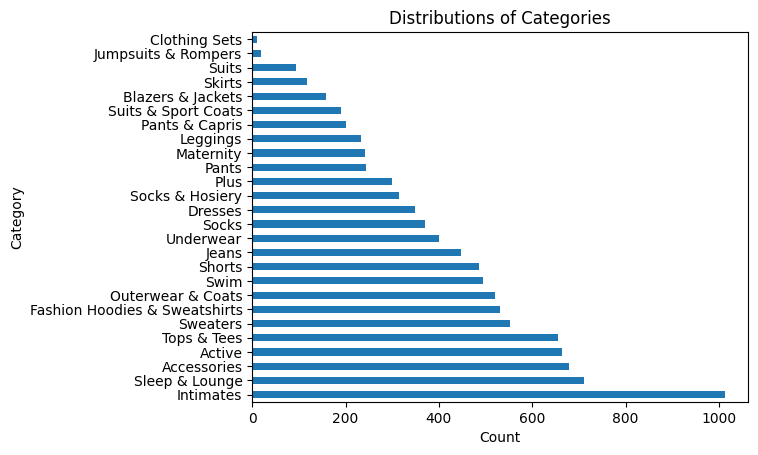

In [17]:
products['category'].value_counts().plot(kind='barh', title='Distributions of Categories', xlabel='Count', ylabel='Category');

Isolating the top 10 product categories:

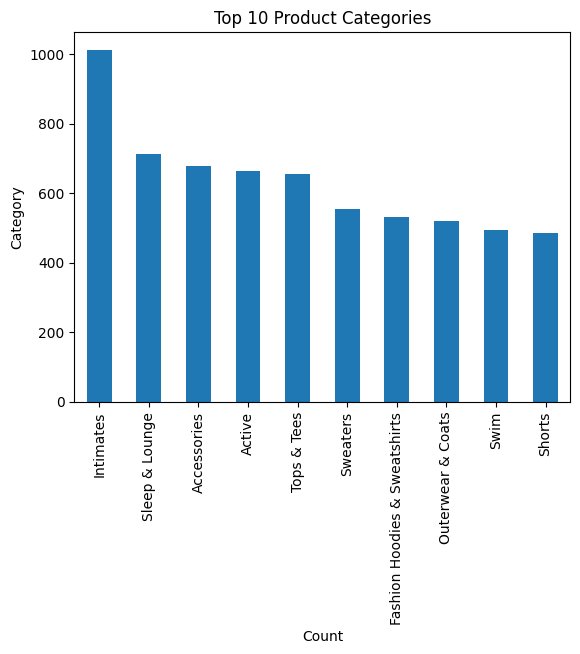

In [255]:
uniqueproducts = products['category'].value_counts()
uniqueproducts.head(10).plot(kind='bar', title='Top 10 Product Categories', xlabel='Count', ylabel='Category');

**Insight:** Most of the products in our sample are the in the Intimates category. This discovery informs us that the density of Intimates is higher than other products, however, that doesn't necessarily mean that Intimate products sell the most so we do not currently have enough information to draw conclusions about business outcomes.

Let's continue exploring product categories by looking at `retatil_price`.

#### Categories with most expensive retail price items

In [ ]:
price_sorted = products.sort_values(by='retail_price', ascending=False)
price_sorted.head()

In [ ]:
# sorting the categories by retail value
sorted_categories = (
    products.groupby('category')['retail_price']
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

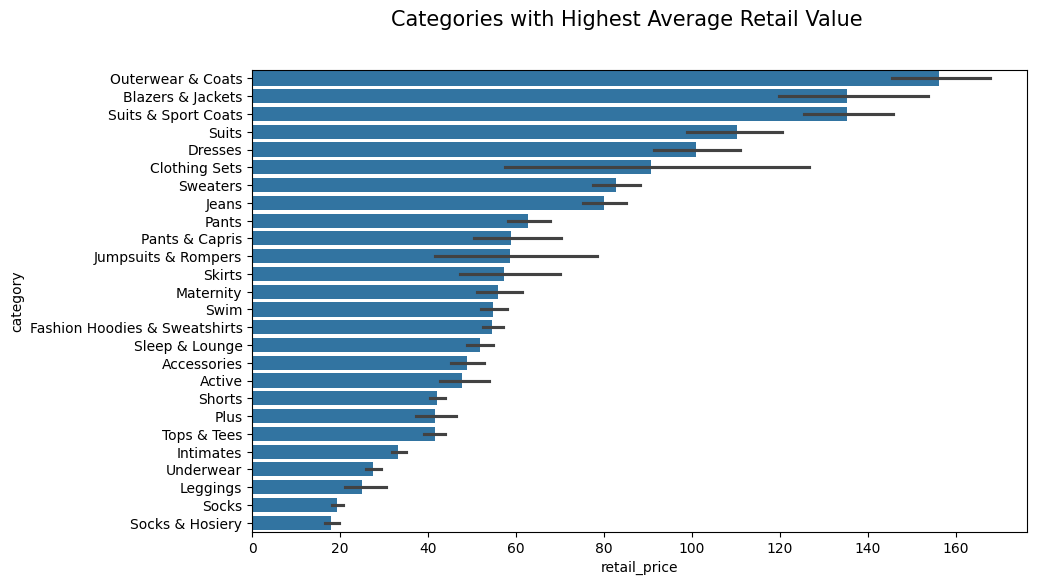

In [98]:
plt.figure(figsize=(10, 6))
plt.suptitle('Categories with Highest Average Retail Value', fontfamily='sans-serif', fontsize= '15');
sns.barplot(data=products,
            x='retail_price',
            y='category',
            order=sorted_categories)
plt.show()

**Insight:** We can see that despite the intimates category being the most prevalent in our sample, the following categories have the highest retail price in order: </br>
1. Outerwear </br>
2. Blazers and jackets </br>
3. Suits & Sports Coats </br>
4. Suits </br>
5. Dresses </br>
6. Clothing Sets </br>
7. Sweaters </br>
8. Jeans & Pants </br>
9. Pants & Capris </br>
10. Jumpsuits & Rompers



 While this is important to know, these findings do not provide enough information as to **which product brings in the most revenue**, which we will explore later on.

#### `department` column

What are the departments represented in this data?

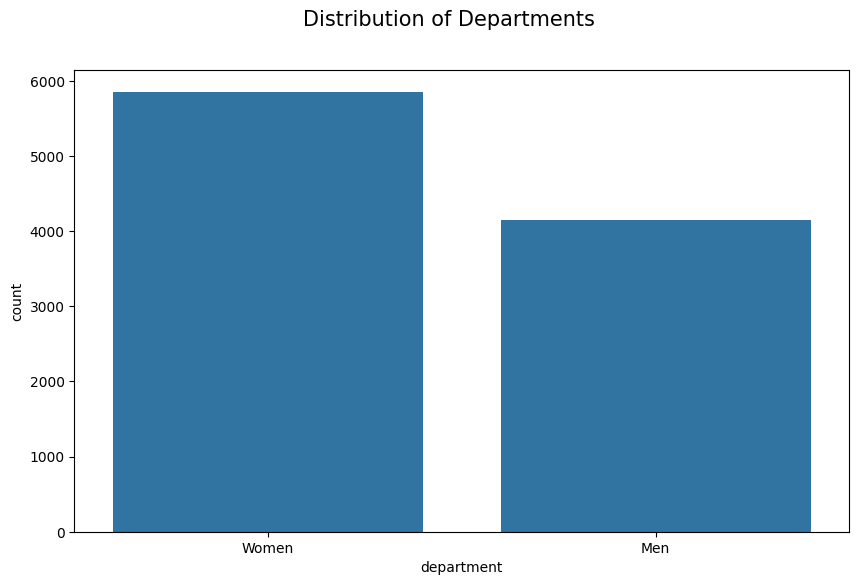

In [137]:
# save the unique values to plot
uniquedepartments = products['department'].value_counts()

plt.figure(figsize=(10, 6))
plt.suptitle('Distribution of Departments', fontfamily='sans-serif', fontsize= '15');
sns.barplot(data=uniquedepartments)
plt.show()

The distribution of the departments indicate that the Women's department is more densely represented in the data.

#### `brand` column
Exploring the most popular brands-- combining brands with 1 item in the data:

In [212]:
uniquebrands = products['brand'].value_counts()
uniquebrandsDF = pd.DataFrame(uniquebrands)

In [200]:
uniquebrandsDF[uniquebrandsDF['count'] == 1]

,level_0,index,brand,count
735,735,735,Fashion,1
736,736,736,FASH Limited,1
737,737,737,Peter Grimm,1
738,738,738,Phases,1
739,739,739,Noppies,1
...,...,...,...,...
1131,1131,1131,Out of Print Clothing,1
1132,1132,1132,Pistol Pete Underwear,1
1133,1133,1133,So Wear it declare it,1
1134,1134,1134,Christmas Story,1


There are over 1136 different brands in our dataset. Out of those brands, there are 401 that have exactly 1 item. We will combine these brands into an "other" category






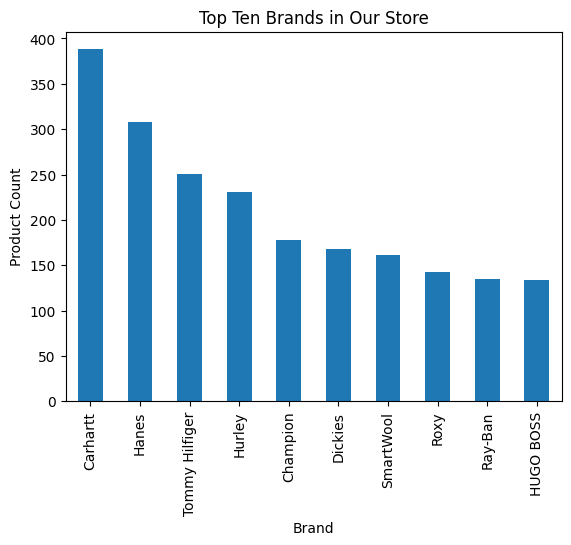

In [304]:
products['brand'].value_counts().head(10).plot(kind='bar', xlabel='Brand', ylabel='Product Count', title='Top Ten Brands in Our Store');

Carhartt is the biggest brand in the data, and they stem across different product categories.

In [203]:
products[products['brand'] == 'Carhartt']

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
8799,114,23.239150,Tops & Tees,Carhartt Women's Midweight Flannel Button Fron...,Carhartt,44.950001,Women,5FD0B37CD7DBBB00F97BA6CE92BF5ADD,3
8800,224,27.072000,Tops & Tees,Carhartt Women's Midweight Work-Dry Thermal Cr...,Carhartt,47.000000,Women,13FE9D84310E77F13A6D184DBF1232F3,3
8801,234,22.314561,Tops & Tees,Carhartt Women's Essential Waffle Henley Shirt,Carhartt,40.720001,Women,289DFF07669D7A23DE0EF88D2F7129E7,3
8802,254,19.925961,Tops & Tees,Carhartt Women's Womens Madison Shirt,Carhartt,32.990002,Women,C52F1BD66CC19D05628BD8BF27AF3AD6,3
8803,304,21.552699,Tops & Tees,Carhartt Women's Lightweight Long Sleeve V-Nec...,Carhartt,36.529999,Women,37BC2F75BF1BCFE8450A1A41C200364C,3
...,...,...,...,...,...,...,...,...,...
9182,28948,13.830381,Accessories,Carhartt Men's Workflex Classic Logo Cap,Carhartt,35.830002,Men,EF9FFA986FA98B2485FE6B57AC0C6B1B,3
9183,28957,19.350000,Accessories,Carhartt Men's Peninsula Trapper Hat,Carhartt,50.000000,Men,F95490B29665F1400527D32A286F63AD,3
9184,28984,12.061790,Accessories,Carhartt Men's Flex Tough Work Glove with Dura...,Carhartt,29.930000,Men,133CC6B5565F9A47831EEEA9854A29A2,3
9185,29021,17.488740,Accessories,Carhartt A148 Men's Sandstone Arctic-Quilt Lin...,Carhartt,40.020000,Men,4A850ECFB32EFA4F6E894ED5B631D445,3


In [309]:
products[products['brand'] == 'Hanes']

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
8020,140,7.10553,Tops & Tees,Hanes 5680 Ladies 5 oz. ComfortSoft Cotton T-S...,Hanes,12.99,Women,1385974ED5904A438616FF7BDB3F7439,3
8021,182,5.66008,Tops & Tees,Hanes Women's Relax Fit Jersey V-Neck Tee 5.2 ...,Hanes,10.18,Women,4C5BDE74A8F110656874902F07378009,3
8022,192,11.37431,Tops & Tees,Hanes Ladies Moisture Wicking Performance T-Shirt,Hanes,19.99,Women,58A2FC6ED39FD083F55D4182BF88826D,3
8023,220,15.17816,Tops & Tees,Hanes 7 oz Cotton Pique Women's Polo Shirt. 035,Hanes,25.99,Women,EC8CE6ABB3E952A85B8551BA726A1227,3
8024,360,6.65500,Tops & Tees,HANES 4.2 oz NANO-T Originals V-Neck T-Shirt -...,Hanes,11.00,Women,E7B24B112A44FDD9EE93BDF998C6CA0E,3
...,...,...,...,...,...,...,...,...,...
8323,26760,13.01566,Sleep & Lounge,Men's Hanes Long-sleeve Crew Top w/ Flannel Pa...,Hanes,29.99,Men,73BF740ED941E13E76E67049A5165B91,3
8324,26885,8.21589,Sleep & Lounge,Hanes Long SleeveSport Style Crew Top and Flee...,Hanes,19.99,Men,EDE08F3AE4D17D223051ED8282A67CAF,3
8325,26934,4.83197,Sleep & Lounge,Hanes Blue Plaid Cotton Knit Pajama Pants for Men,Hanes,11.99,Men,06CBF6501DCDEAFC6FC5120FE39249E8,3
8326,26936,10.88637,Sleep & Lounge,Hanes Long Sleeve Long Leg Broadcloth Pajamas,Hanes,29.99,Men,91AB07539B36F85BA8180D74AD2BB3EE,3


In [306]:
products[products['brand'] == 'Hanes']['category'].value_counts()

,count
category,
Underwear,94
Intimates,69
Socks & Hosiery,34
Active,31
Socks,31
Tops & Tees,20
Sleep & Lounge,16
Plus,12
Pants & Capris,1


Hanes is the second most carried brand in our store, it contributes to the intimates category, which has the highest product density.

What brand, on average, has the highest retail price of items?

In [208]:
expensivebrands = products.groupby('brand')['retail_price'].mean().sort_values(ascending=False)
expensivebrands.head(20)

,retail_price
brand,
Bergama,749.989990
Canada Goose,581.382223
Moncler,550.000000
Magaschoni,408.500000
Overland Sheepskin Co,369.600000
Halston Heritage,363.651662
Evisu,349.170013
ILSE JACOBSEN,345.000000
Arc'teryx,306.521250


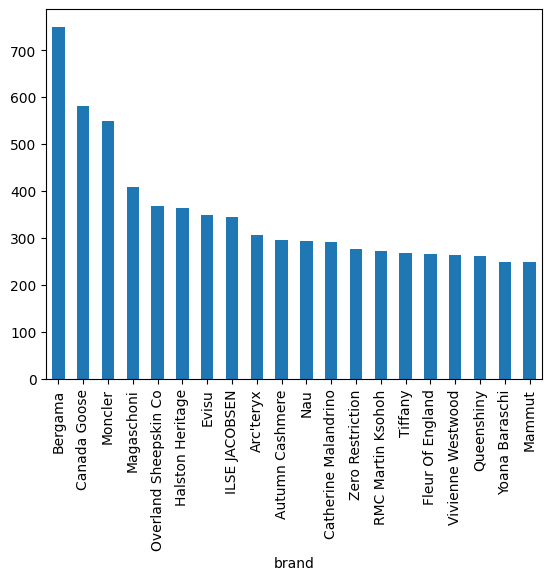

In [209]:
expensivebrands.head(20).plot(kind='bar');

In [210]:
products[products['brand'] == 'Bergama']

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
8606,8777,306.745905,Outerwear & Coats,Bergama Natural Raccoon Hooded Stroller - - Mu...,Bergama,749.98999,Women,9399E0B02C73FCC14CD11D9B4E685F2E,3


In [234]:
products[products['brand'] == 'Canada Goose']

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
2463,2557,280.500001,Active,Canada Goose Women's Mystique,Canada Goose,750.0,Women,1680829293F2A8541EFA2647A0290F88,1
2464,2719,261.320001,Active,Canada Goose Women's Solaris,Canada Goose,695.0,Women,7AEE26C309DEF8C5A2A076EB250B8F36,1
2465,2735,105.600001,Active,Canada Goose Women's Freestyle Vest,Canada Goose,275.0,Women,1D49780520898FE37F0CD6B41C5311BF,1
2466,8300,395.910000,Outerwear & Coats,Canada Goose Women's Expedition Parka,Canada Goose,795.0,Women,9B40AEE76034C9543CEACBA5DF759A1D,1
2467,8319,353.249999,Outerwear & Coats,Canada Goose Women's Mystique,Canada Goose,750.0,Women,3941C4358616274AC2436EACF67FAE05,1


Though Bergama is the most expensive brand, there is only one item from this brand, which also happens to be in the Outerwear & Coats category, further contributing to our insights of the most expensive categories.

Let's evaluate the average retail price and the average retail price for items from the top ten most prominent brands and categories:

In [254]:
avgPrice = products['retail_price'].mean()
print(f'The average retail price for all products is {avgPrice}')

The average retail price for all products is 58.690161070515586


In [301]:
topTenProds = products['brand'].value_counts().head(10)
topTenProds

avgCounts = 0
for brand in topTenProds.index:

  print(f' For {brand} the average price is {products[products["brand"] == brand]["retail_price"].mean()}')
  prodMn = products[products["brand"] == brand]["retail_price"].mean()
  avgCounts += prodMn

print()
print(f'The pooled average retail price for the top ten brands in our sample is {round(avgCounts/10, 3)}')

 For Carhartt the average price is 68.74765422172153
 For Hanes the average price is 19.71204546364871
 For Tommy Hilfiger the average price is 73.44569725629343
 For Hurley the average price is 50.879567043089764
 For Champion the average price is 35.95780879995796
 For Dickies the average price is 41.409881106444764
 For SmartWool the average price is 52.92099389970673
 For Roxy the average price is 49.9907693596153
 For Ray-Ban the average price is 117.27296295166016
 For HUGO BOSS the average price is 42.37671666358834

The pooled average retail price for the top ten brands in our sample is 55.271


 This means that if were to sell any of the items from the top ten biggest brands that make up our inventory, we'd have an average retail price of $55.27.  

**Insights:** Identifying the most prominent brands in our store can help us establish partnerships with other businesses and drive inventory decisions and marketing decisions.

In [315]:
# The average price per category
products.groupby('category')['retail_price'].mean()

,retail_price
category,
Accessories,48.945243
Active,47.834118
Blazers & Jackets,135.331510
Clothing Sets,90.717272
Dresses,101.017414
Fashion Hoodies & Sweatshirts,54.665830
Intimates,33.272174
Jeans,80.084330
Jumpsuits & Rompers,58.630000


In [ ]:
# plotting distributions of items

Let's look at the distributions of values for the different columns.

### Order Exploration
We'll start this exploration by investigating products that are most ordered, order frequency and information about the ordering process. Some questions we aim to answer here are:

* What was the highest selling product?
* How often was this product ordered?
* How much revenue did the top products bring in?
* Is there a seasonality or trend associated with this product?